In [1]:
import pymc3 as pm

In [2]:
from collections import OrderedDict
import warnings
import theano
import numpy as np

In [3]:
import pandas as pd
import theano.tensor as tt
import seaborn as sns

In [132]:
class ConstantStochasticGradient(pm.step_methods.sgmcmc.BaseStochasticGradient):
    R"""
    ConstantStochasticGradient: approximates stochastic variational inference
    
    It approximates stochastic variational inference
    where it differs from SGFS and many other MCMC techniques which
    converge towards the exact posterior. In comparison to SGFS the paper 
    discusses a proof for the optimal preconditioning matrix
    based on variational inference, so there is no additional input.
     
    Parameters
    -----
    vars : list
        model variables

    References
    -----
    -   Stochastic Gradient Descent as Approximate Bayesian Inference
        https://arxiv.org/pdf/1704.04289v1.pdf
    """

    def __init__(self, vars=None, **kwargs):
        """
        Parameters
        ----------
        vars : list 
            Theano variables, default continuous vars
        kwargs: passed to BaseHMC
        """
        super(ConstantStochasticGradient, self).__init__(vars, **kwargs)

    def _initialize_values(self):
        # Init avg_C: Noise Covariance Moving Average
        self.avg_C = theano.shared(np.zeros((self.q_size, self.q_size)), name='avg_C')
        self.t = theano.shared(1, name='t')
        # Init training fn
        self.training_fn = self.mk_training_fn()

    def mk_training_fn(self):
        """The Constant Stochastic Gradient Step Fn with Optimal Preconditioning Matrix"""
        q_size = self.q_size
        avg_C = self.avg_C
        t = self.t
        updates = self.updates
        # Trying to stick to variables names as given in the publication
        # https://arxiv.org/pdf/1704.04289v1.pdf
        S = self.batch_size
        N = self.total_size
        
        # inputs
        random = self.random
        inarray = self.inarray
        
        # gradient of log likelihood
        gt = -1 * (1./S) * (self.dlogp_elemwise.sum(axis=0) + (S/N)*self.dlog_prior)    

        # update moving average of Noise Covariance
        gt_diff = (self.dlogp_elemwise - self.dlogp_elemwise.mean(axis=0))
        V = (1./(S-1)) * theano.dot(gt_diff.T, gt_diff)
        C_t = (1. - 1. / t) * avg_C + (1. / t) * V        
        # BB^T = C 
        B = tt.switch(t <= int(N/S), tt.eye(q_size), tt.slinalg.cholesky(C_t))            
        # Optimal Preconditioning Matrix
        H = (2.*S/N)*tt.nlinalg.matrix_inverse(C_t)
        # step value on the log likelihood gradient preconditioned with H
        step = -1*theano.dot(H, gt.dimshuffle([0, 'x'])) 
        
        # sample gaussian noise dW
        dW = random.normal((q_size, 1), dtype=theano.config.floatX, avg=0.0, std=1.0)        
        # noise term is inversely proportional to batch size
        noise_term = (1./np.sqrt(S))*theano.dot(H, theano.dot(B, dW))
        # step + noise term
        dq = (step + noise_term).flatten()
        
        # update time and avg_C 
        updates.update({avg_C: C_t, t: t + 1})
        
        f = theano.function(
            outputs=dq,
            inputs=inarray,
            updates=updates,
            allow_input_downcast=True)

        return f
        
    @staticmethod
    def competence(var):
        if var.dtype in continuous_types:
            return Competence.COMPATIBLE
        return Competence.INCOMPATIBLE

In [133]:
batch_size = 50
raw_data = pd.read_csv('/Users/shashank/Downloads/CASP.csv', delimiter=',')
train_df = (raw_data - raw_data.mean())/raw_data.std()
N = train_df.shape[0]
q_size = train_df.shape[1]-1
q_name = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9']


def x_gen():
    i = -1
    while True:
        i += 1
        if (N-(i*batch_size)) < batch_size:
            i = 0
        yield train_df.ix[ i*batch_size : ((i+1)*batch_size)-1][q_name].as_matrix()
        
def y_gen():
    i = -1
    while True:
        i += 1
        if (N-(i*batch_size)) < batch_size:
            i = 0
        yield train_df.ix[ i*batch_size : ((i+1)*batch_size)-1]['RMSD'].as_matrix()        
        
X = pm.generator(gen=x_gen())
Y = pm.generator(gen=y_gen())        

with pm.Model() as model:
    # Unknown parameters
    b0 = pm.Normal("Intercept", mu=0.0, sd=1.0)
    b1 = pm.Normal("Slope", mu=0.0, sd=1.0, shape=(q_size,))
    std = pm.HalfNormal("std", sd=1.0)

    # Identity Link Function
    mu = b0 + theano.dot(X, b1)      
    y_obs = pm.Normal("y_obs", mu=mu, sd=std, observed=Y)

    
draws = 5000

with model:
    csg_step_method = ConstantStochasticGradient(vars=model.vars, total_size=N, batch_size=batch_size) 
    csg_trace = pm.sample(draws=draws, step=csg_step_method, init=None) 
    
with model:
    sgfs_step_method = pm.step_methods.SGFS(vars=model.vars, step_size=1.0, total_size=N, batch_size=batch_size)    
    sgfs_trace = pm.sample(draws=draws, step=sgfs_step_method, init=None) 

100%|██████████| 5500/5500 [00:11<00:00, 467.08it/s]


## Posterior Distribution of Theta values

In [ ]:
from sklearn.decomposition import PCA

_sigma_inv = np.linalg.inv(csg_step_method.avg_C.eval())
_trace = csg_trace

posterior_dist = []
stationary_dist = []
total_weight = sum(map(lambda theta: np.exp(-(1./2)*np.matmul(np.matmul(bij.map(theta).T, _sigma_inv), bij.map(theta))), _trace))
for theta in _trace:
    posterior_dist.append(theta)
    print(-(1./2)*np.matmul(np.matmul(bij.map(theta).T, _sigma_inv), bij.map(theta)))
    z2 = np.exp((-(1./2)*np.matmul(np.matmul(bij.map(theta).T, _sigma_inv), bij.map(theta))))/total_weight
    if np.random.uniform(low=0, high=1, size=1)[0] <= z2:
        stationary_dist.append(theta)

## Constant Stochastic Gradient Traceplot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11827e890>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1178a6310>]], dtype=object)

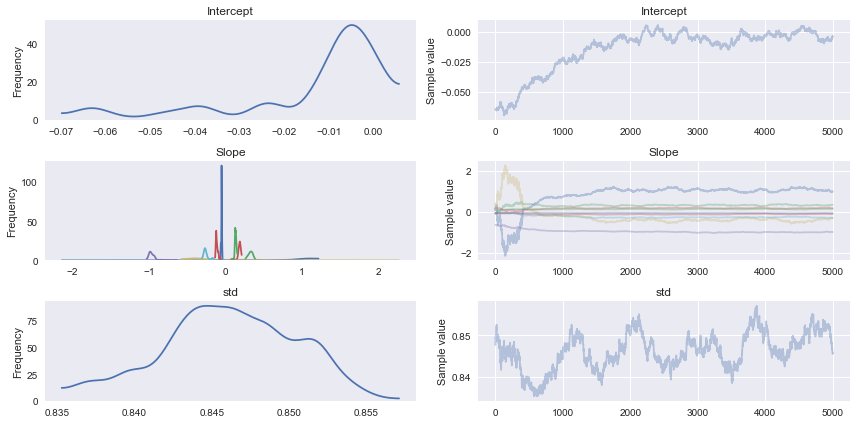

In [134]:
pm.traceplot(csg_trace)

## SGFS Trace Plot

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114290990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11720e050>]], dtype=object)

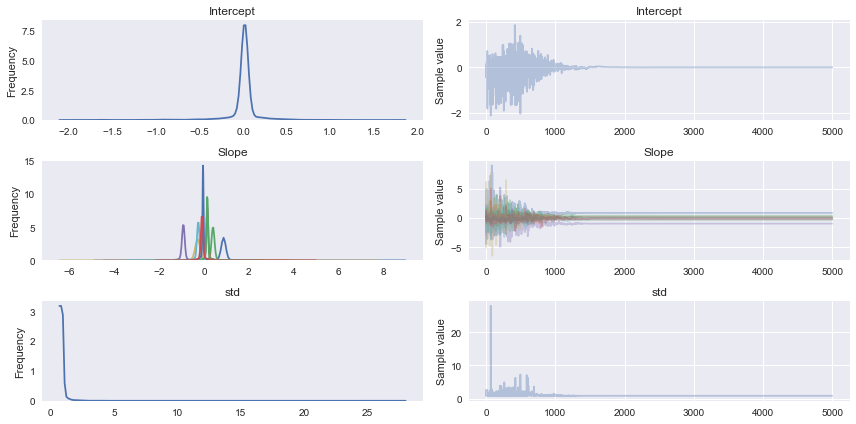

In [19]:
pm.traceplot(sgfs_trace)

## Example Figure from Publication

## 2 D Map comparing sampling between SGFS and CSG